In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as im_pipe
from sklearn.pipeline import Pipeline as sk_pipe
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.base import clone
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
employee_df = pd.read_csv('~/Documents/Data Science/2nd Semester/Data Science Bootcamp/Project datasets-20220912/DATASET_-_NOVA_IMS_-_Human-Resources-Employee-Attrition.docx/HR_DS.csv')
employee_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
employee_df.shape

(1470, 35)

We seem to have little data to work with. We probably cannot divide the data in TRAIN and VALIDATION. Use K-Fold CV.

In [4]:
employee_df.columns.tolist()

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [5]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
employee_df.Over18.value_counts()

Y    1470
Name: Over18, dtype: int64

In [7]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

There are no missing values in our dataset.

In [8]:
employee_df[employee_df.duplicated(keep = False)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


No duplicates found!

### Target Distribution

<AxesSubplot:xlabel='Attrition', ylabel='Count'>

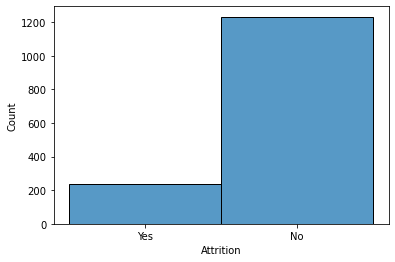

In [9]:
sns.histplot(data = employee_df.Attrition, legend= True)

We have a imbalanced dataset, since most of our observations have a target of 'No'. We must take this into account when using evaluation metrics.

### Numerical Variables

In [10]:
employee_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


EmployeeCount and StandardHours are univariate features and should be dropped as they don't provide relevant information to the problem. 

EmployeeNumber don't seem relevant also, set as index.

In [11]:
employee_df.set_index('EmployeeNumber', inplace= True)
employee_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,...,4,80,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,...,3,80,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,4,80,1,6,3,3,2,2,2,2


In [12]:
employee_df.drop(columns= ['EmployeeCount', 'StandardHours', 'Over18'], axis = 1, inplace = True)

In [13]:
employee_df.skew()

Age                         0.413286
DailyRate                  -0.003519
DistanceFromHome            0.958118
Education                  -0.289681
EnvironmentSatisfaction    -0.321654
HourlyRate                 -0.032311
JobInvolvement             -0.498419
JobLevel                    1.025401
JobSatisfaction            -0.329672
MonthlyIncome               1.369817
MonthlyRate                 0.018578
NumCompaniesWorked          1.026471
PercentSalaryHike           0.821128
PerformanceRating           1.921883
RelationshipSatisfaction   -0.302828
StockOptionLevel            0.968980
TotalWorkingYears           1.117172
TrainingTimesLastYear       0.553124
WorkLifeBalance            -0.552480
YearsAtCompany              1.764529
YearsInCurrentRole          0.917363
YearsSinceLastPromotion     1.984290
YearsWithCurrManager        0.833451
dtype: float64

NumCompaniesWorked, PerformanceRating, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion seem to be highly skewed and might contain a few outliers.

<AxesSubplot:xlabel='NumCompaniesWorked', ylabel='Count'>

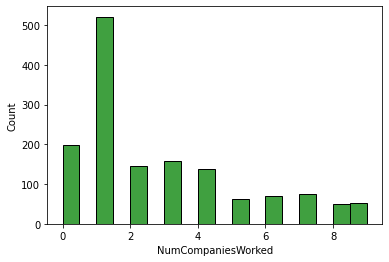

In [14]:
sns.histplot(employee_df.NumCompaniesWorked, color = 'g')

3    1244
4     226
Name: PerformanceRating, dtype: int64


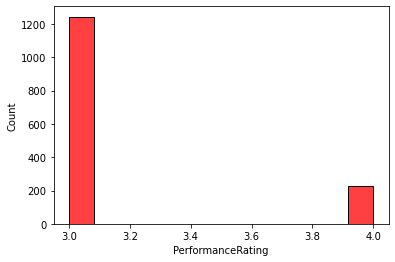

In [15]:
sns.histplot(employee_df.PerformanceRating, color = 'r')
print(employee_df.PerformanceRating.value_counts())

Weird values in Performance Rating, only 3 and 4 values?

<AxesSubplot:xlabel='TotalWorkingYears', ylabel='Count'>

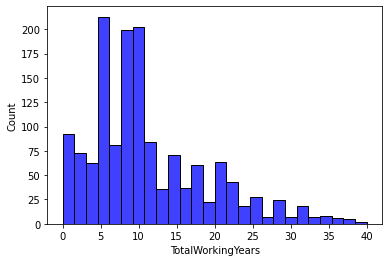

In [16]:
sns.histplot(employee_df.TotalWorkingYears, color = 'b')

<AxesSubplot:xlabel='YearsAtCompany', ylabel='Count'>

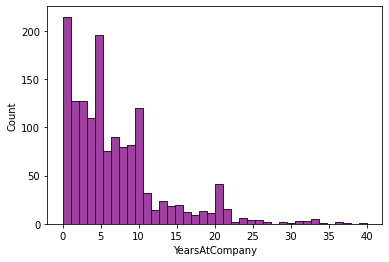

In [17]:
sns.histplot(employee_df.YearsAtCompany, color = 'purple')

<AxesSubplot:ylabel='YearsAtCompany'>

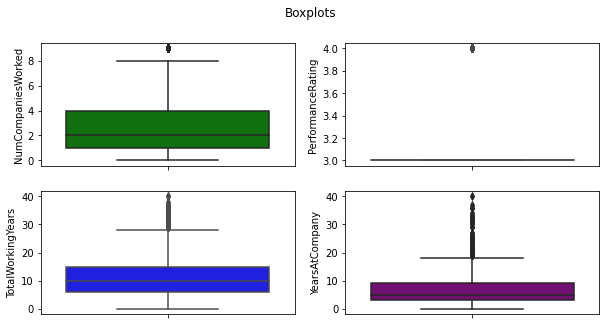

In [18]:
figure, axes = plt.subplots(2, 2, sharex= False, figsize=(10,5))
figure.suptitle('Boxplots')

sns.boxplot(ax= axes[0, 0], data= employee_df, y= 'NumCompaniesWorked', color= 'g')
sns.boxplot(ax= axes[0, 1], data= employee_df, y= 'PerformanceRating', color= 'r')
sns.boxplot(ax= axes[1, 0], data= employee_df, y= 'TotalWorkingYears', color= 'b')
sns.boxplot(ax= axes[1, 1], data= employee_df, y= 'YearsAtCompany', color= 'purple')

<AxesSubplot:>

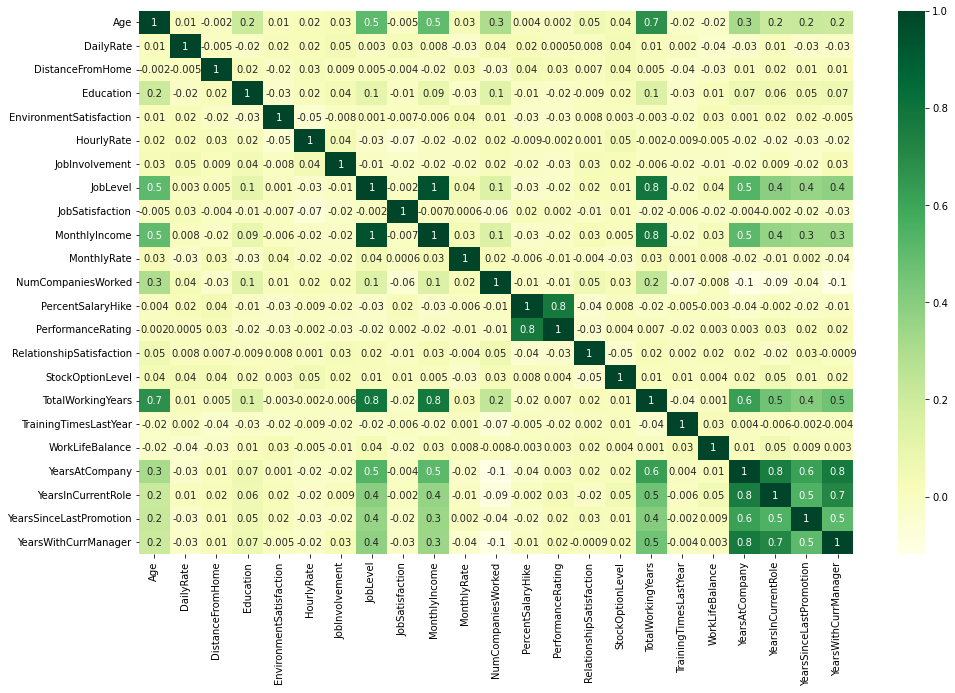

In [19]:
df_corr = employee_df.corr(method = 'pearson')
figure = plt.figure(figsize = (16, 10))
sns.heatmap(df_corr, cmap = 'YlGn',annot = True, fmt = '.1g')

<AxesSubplot:>

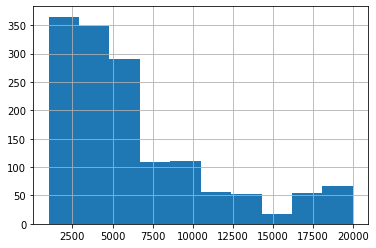

In [20]:
employee_df.MonthlyIncome.hist()

### Cateforical Variables

In [21]:
employee_df.describe(include = ['O']) # incluir as variáveis categóricas no describe

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No
freq,1233,1043,961,606,882,326,673,1054


No NaN values found in categorical variables.

As seen previously Attrition possesses for the most time the value "No", people tend to travel rarely, do R&D, come from Life Sciences and are Male most of the time.

The most frequent Job Role is Sales Executive, more than half of employees are Married and more than 2/3 don't do overtime.

# Data Pre Processing

### Dummify Target Variable

In [22]:
employee_df.Attrition.replace(to_replace= ['Yes', 'No'], value= [1, 0], inplace= True)
employee_df.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

### Separate Labels from Features

In [23]:
labels = employee_df[['Attrition']].copy()
labels.sample(5)

,Attrition
EmployeeNumber,
299,1
475,0
783,0
1604,1
1692,1


In [24]:
employee_df = employee_df.drop('Attrition', axis = 1)
employee_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,...,3,1,0,8,0,1,6,4,0,5
2,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,...,4,4,1,10,3,3,10,7,1,7
4,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,...,3,2,0,7,3,3,0,0,0,0
5,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
7,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,...,3,4,1,6,3,3,2,2,2,2


### Separate Categorical variables from Numerical

In [25]:
employee_df.dtypes

Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsInCurrentRole           int64
YearsSinceLastPromot

In [26]:
df_num = employee_df.drop(columns= ['BusinessTravel', 'Department', 'EducationField', 'Gender', 
                                    'JobRole', 'MaritalStatus', 'OverTime'])
df_cat = employee_df[['BusinessTravel', 'Department', 'EducationField', 'Gender', 
                                    'JobRole', 'MaritalStatus', 'OverTime']]

In [27]:
list_num = df_num.columns.tolist()
list_cat = df_cat.columns.tolist()

In [28]:
cat_pipepline = sk_pipe([('encoder', OneHotEncoder(categories= 'auto'))])
num_pipeline = sk_pipe([('std_scaler', StandardScaler())])

In [29]:
employee_cat = cat_pipepline.fit_transform(df_cat) # apply the pipeline to cat data
employee_num = num_pipeline.fit_transform(df_num) # apply the pipeline to num data

In [30]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, list_num),
    ('cat', cat_pipepline, list_cat),
])

In [31]:
employee_array_prepared = full_pipeline.fit_transform(employee_df)

In [32]:
employee_array_prepared

array([[ 0.4463504 ,  0.74252653, -1.01090934, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.32236521, -1.2977746 , -0.14714972, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.008343  ,  1.41436324, -0.88751511, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.08667552, -1.60518328, -0.64072665, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.32236521,  0.54667746, -0.88751511, ...,  0.        ,
         1.        ,  0.        ],
       [-0.32016256, -0.43256792, -0.14714972, ...,  0.        ,
         1.        ,  0.        ]])

In [33]:
employee_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,...,3,1,0,8,0,1,6,4,0,5
2,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,...,4,4,1,10,3,3,10,7,1,7
4,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,...,3,2,0,7,3,3,0,0,0,0
5,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
7,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,41,...,3,3,1,17,3,3,5,2,0,3
2062,39,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,42,...,3,1,1,9,5,3,7,7,1,7
2064,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,...,4,2,1,6,0,3,6,2,0,3


#### Transform prepared array back to dataframe

In [34]:
cat_cols_encoded = []
for col in list_cat:
    cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(employee_df[col].unique())]

cat_cols_encoded

['B_Travel_Rarely',
 'B_Travel_Frequently',
 'B_Non-Travel',
 'D_Sales',
 'D_Research & Development',
 'D_Human Resources',
 'E_Life Sciences',
 'E_Other',
 'E_Medical',
 'E_Marketing',
 'E_Technical Degree',
 'E_Human Resources',
 'G_Female',
 'G_Male',
 'J_Sales Executive',
 'J_Research Scientist',
 'J_Laboratory Technician',
 'J_Manufacturing Director',
 'J_Healthcare Representative',
 'J_Manager',
 'J_Sales Representative',
 'J_Research Director',
 'J_Human Resources',
 'M_Single',
 'M_Married',
 'M_Divorced',
 'O_Yes',
 'O_No']

In [35]:
len(employee_cat.toarray()[0])

28

In [36]:
employee_num

array([[ 0.4463504 ,  0.74252653, -1.01090934, ..., -0.0632959 ,
        -0.67914568,  0.24583399],
       [ 1.32236521, -1.2977746 , -0.14714972, ...,  0.76499762,
        -0.36871529,  0.80654148],
       [ 0.008343  ,  1.41436324, -0.88751511, ..., -1.16768726,
        -0.67914568, -1.15593471],
       ...,
       [-1.08667552, -1.60518328, -0.64072665, ..., -0.61549158,
        -0.67914568, -0.31487349],
       [ 1.32236521,  0.54667746, -0.88751511, ...,  0.48889978,
        -0.67914568,  1.08689522],
       [-0.32016256, -0.43256792, -0.14714972, ..., -0.33939374,
        -0.36871529, -0.59522723]])

In [37]:
employee_df_prepared_cat = pd.DataFrame(employee_cat.toarray(), columns= cat_cols_encoded, 
                                      index= df_cat.index) ## transformar para um df as categóricas
employee_df_prepared_num = pd.DataFrame(employee_num, columns= df_num.columns,
                                       index= df_num.index) ## transformar para um df as numéricas

employee_df_prepared = employee_df_prepared_num.merge(employee_df_prepared_cat, how= 'left',
                                                     on= employee_df_prepared_num.index)
employee_df_prepared.rename(columns= {"key_0": "EmployeeNumber"}, inplace= True)
employee_df_prepared.set_index('EmployeeNumber', inplace= True)
employee_df_prepared

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,J_Healthcare Representative,J_Manager,J_Sales Representative,J_Research Director,J_Human Resources,M_Single,M_Married,M_Divorced,O_Yes,O_No
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,0.446350,0.742527,-1.010909,-0.891688,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.322365,-1.297775,-0.147150,-1.868426,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.008343,1.414363,-0.887515,-0.891688,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,-0.429664,1.461466,-0.764121,1.061787,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,-1.086676,-0.524295,-0.887515,-1.868426,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,-0.101159,0.202082,1.703764,-0.891688,0.254625,-1.224807,1.785511,-0.057788,1.153254,-0.835451,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2062,0.227347,-0.469754,-0.393938,-1.868426,1.169781,-1.175601,-1.026167,0.845911,-1.567907,0.741140,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2064,-1.086676,-1.605183,-0.640727,0.085049,-0.660531,1.038693,1.785511,-0.057788,-0.660853,-0.076690,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Select and Train a Model

### Decision Tree Classifier

### Without SMOTE

In [38]:
dec_tree_clf = DecisionTreeClassifier()
dec_tree_clf.fit(employee_df_prepared, labels)

DecisionTreeClassifier()

In [39]:
scores = cross_val_score(dec_tree_clf, employee_df_prepared, labels, cv=3, scoring= "roc_auc") # colocar StratifiedKFold

In [40]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.629


### With SMOTE

In [41]:
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared, labels, scoring= 'roc_auc', cv=cv, n_jobs= -1)

In [42]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.637


## Random Forest

### Without SMOTE

In [43]:
rf_clf = RandomForestClassifier(n_estimators= 10, class_weight= 'balanced_subsample')
rf_clf.fit(employee_df_prepared, labels)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=10)

In [44]:
# Define a evaluation method
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3)

In [45]:
scores = cross_val_score(rf_clf, employee_df_prepared, labels, cv= cv, scoring= "roc_auc")

In [46]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.736


### With SMOTE

In [47]:
warnings.filterwarnings('ignore')
steps = [('over', SMOTE()), ('model', RandomForestClassifier(n_estimators= 10, class_weight= 'balanced_subsample'))]
pipeline = im_pipe(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, employee_df_prepared, labels, scoring='roc_auc', cv=cv, n_jobs=-1)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:272:

In [48]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.755


#### Feature Importance - Random Forest

In [49]:
gini_importance_rf = RandomForestClassifier(n_estimators = 10, class_weight= 'balanced_subsample', 
                                            criterion = 'gini')
gini_importance_fit_rf = gini_importance_rf.fit(employee_df_prepared, labels).feature_importances_
entropy_importance_rf = RandomForestClassifier(n_estimators = 10, class_weight= 'balanced_subsample',
                                               criterion = 'entropy')
entropy_importance_fit_rf = entropy_importance_rf.fit(employee_df_prepared, labels).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

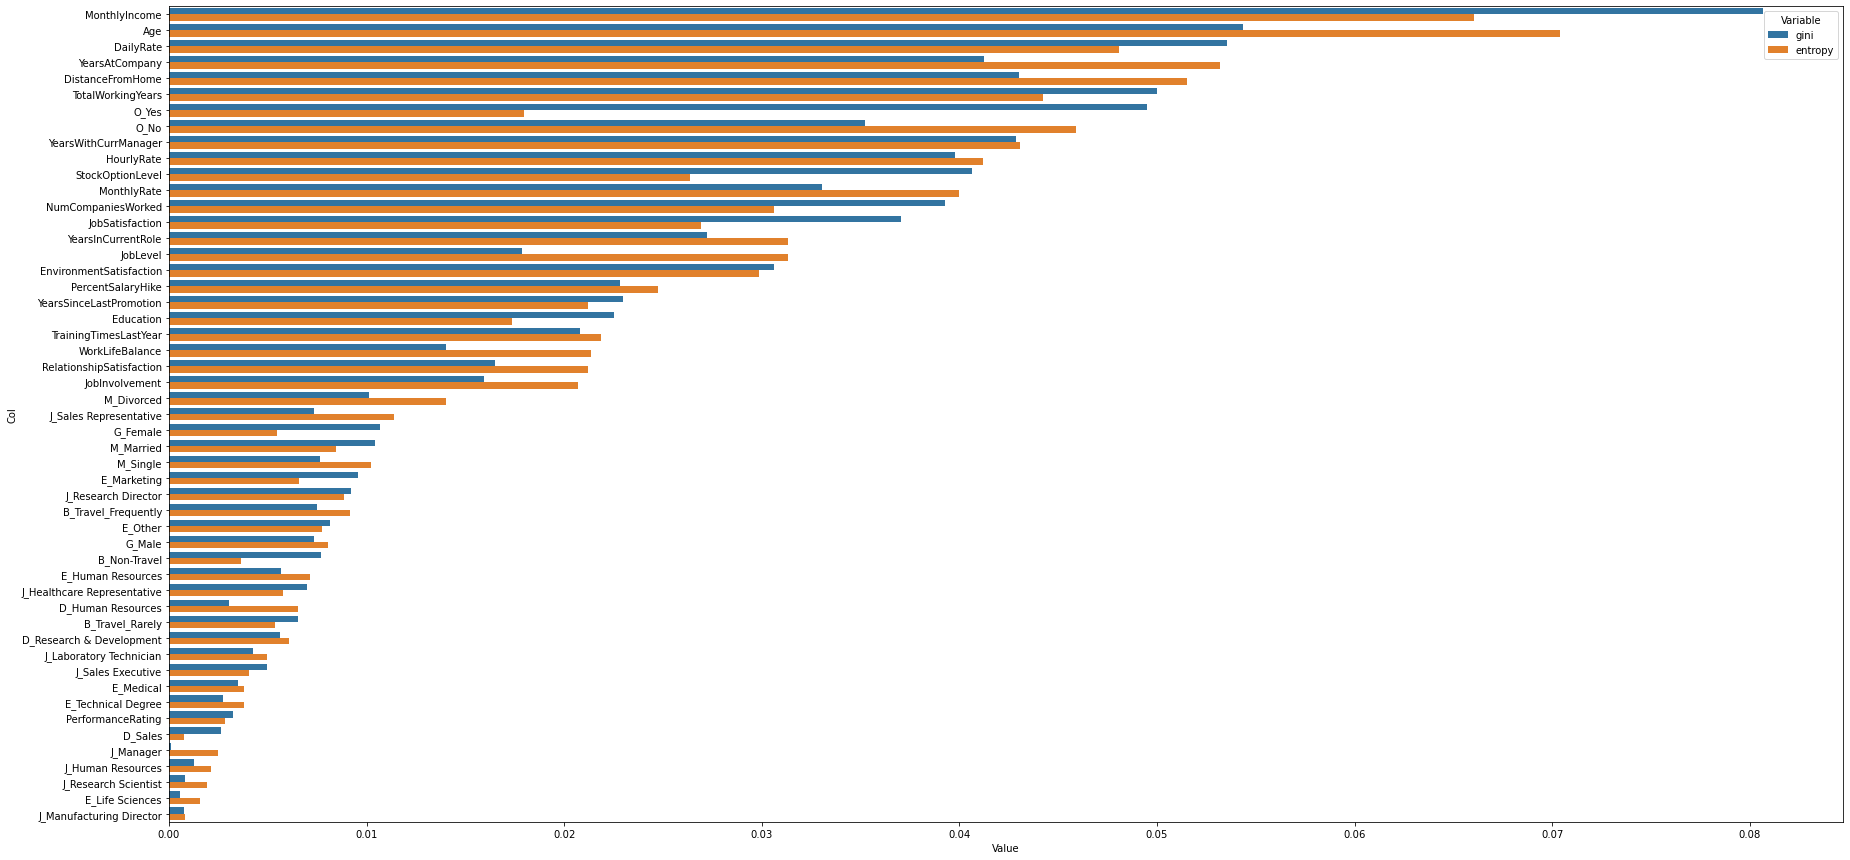

In [50]:
zippy = pd.DataFrame(zip(gini_importance_fit_rf, entropy_importance_fit_rf), columns = ['gini','entropy'])
zippy['col'] = employee_df_prepared.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(30,15))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

## XGBoost

### Without SMOTE

In [51]:
steps = [('model', XGBClassifier(scale_pos_weight= 0.1))]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)

In [52]:
scores

array([0.74356369, 0.83638211, 0.84891599, 0.80149051, 0.87127371,
       0.82689702, 0.86280488, 0.81030856, 0.74754558, 0.80014025,
       0.7645664 , 0.81571816, 0.88211382, 0.77913279, 0.88821138,
       0.7449187 , 0.7804878 , 0.878331  , 0.74123422, 0.7871669 ,
       0.76897019, 0.78929539, 0.86144986, 0.8800813 , 0.77743902,
       0.72628726, 0.77743902, 0.79382889, 0.88779804, 0.8197756 ])

In [53]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.810


### With SMOTE

In [54]:
steps = [('over', SMOTE()), ('under', RandomUnderSampler()), 
         ('model', XGBClassifier(scale_pos_weight= 0.1))]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared, labels, scoring= 'roc_auc', cv=cv, n_jobs= -1)

In [55]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.805


## AGBoost

### Without SMOTE

In [56]:
steps = [('model', AdaBoostClassifier())]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

In [57]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.819


### With SMOTE

In [58]:
steps = [('over', SMOTE()), ('model', AdaBoostClassifier())]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

In [59]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.821


In [60]:
model = AdaBoostClassifier()
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(model, employee_df_prepared, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

In [61]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.819


## Model Fit and Feature Importance

In [62]:
pipeline.fit(employee_df_prepared, labels)

Pipeline(steps=[('over', SMOTE()), ('model', AdaBoostClassifier())])

In [63]:
pipeline[1].feature_importances_

array([0.04, 0.04, 0.04, 0.  , 0.04, 0.  , 0.06, 0.04, 0.04, 0.04, 0.  ,
       0.04, 0.02, 0.  , 0.02, 0.02, 0.02, 0.04, 0.04, 0.02, 0.  , 0.04,
       0.04, 0.  , 0.04, 0.02, 0.  , 0.  , 0.02, 0.  , 0.04, 0.  , 0.04,
       0.  , 0.02, 0.  , 0.06, 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.02])

In [64]:
employee_df_prepared.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'B_Travel_Rarely',
       'B_Travel_Frequently', 'B_Non-Travel', 'D_Sales',
       'D_Research & Development', 'D_Human Resources', 'E_Life Sciences',
       'E_Other', 'E_Medical', 'E_Marketing', 'E_Technical Degree',
       'E_Human Resources', 'G_Female', 'G_Male', 'J_Sales Executive',
       'J_Research Scientist', 'J_Laboratory Technician',
       'J_Manufacturing Director', 'J_Healthcare Representative', 'J_Manager',
       'J_Sales Representative', 'J_Research Director', 'J_Human Resources',
    

In [65]:
pd.set_option('display.max_columns', 500)
feat_imp = pd.DataFrame({'Features': employee_df_prepared.columns, 'Importance': pipeline[1].feature_importances_})
feat_imp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
Features,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,B_Travel_Rarely,B_Travel_Frequently,B_Non-Travel,D_Sales,D_Research & Development,D_Human Resources,E_Life Sciences,E_Other,E_Medical,E_Marketing,E_Technical Degree,E_Human Resources,G_Female,G_Male,J_Sales Executive,J_Research Scientist,J_Laboratory Technician,J_Manufacturing Director,J_Healthcare Representative,J_Manager,J_Sales Representative,J_Research Director,J_Human Resources,M_Single,M_Married,M_Divorced,O_Yes,O_No
Importance,0.04,0.04,0.04,0.0,0.04,0.0,0.06,0.04,0.04,0.04,0.0,0.04,0.02,0.0,0.02,0.02,0.02,0.04,0.04,0.02,0.0,0.04,0.04,0.0,0.04,0.02,0.0,0.0,0.02,0.0,0.04,0.0,0.04,0.0,0.02,0.0,0.06,0.0,0.0,0.04,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.04,0.0,0.0,0.02


In [66]:
columns_to_drop = feat_imp[feat_imp.Importance == 0].Features.tolist()

In [67]:
employee_df_prepared_feature_importance = employee_df_prepared.copy()
employee_df_prepared_feature_importance.drop(columns= columns_to_drop, axis= 1, inplace= True)

In [68]:
steps = [('over', SMOTE()), ('model', AdaBoostClassifier())]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared_feature_importance, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

In [69]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.834


In [70]:
pipeline.fit(employee_df_prepared_feature_importance, labels)

Pipeline(steps=[('over', SMOTE()), ('model', AdaBoostClassifier())])

In [71]:
pipeline[1].feature_importances_

array([0.02, 0.02, 0.04, 0.04, 0.08, 0.04, 0.06, 0.04, 0.04, 0.  , 0.02,
       0.06, 0.02, 0.04, 0.02, 0.02, 0.06, 0.04, 0.04, 0.02, 0.04, 0.04,
       0.04, 0.02, 0.06, 0.04, 0.02, 0.  , 0.02])

In [72]:
feat_imp_v2 = pd.DataFrame({'Features': employee_df_prepared_feature_importance.columns, 'Importance': pipeline[1].feature_importances_})
feat_imp_v2.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
Features,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,B_Travel_Frequently,B_Non-Travel,D_Human Resources,E_Other,E_Marketing,E_Human Resources,G_Male,J_Laboratory Technician,J_Sales Representative,M_Married,O_No
Importance,0.02,0.02,0.04,0.04,0.08,0.04,0.06,0.04,0.04,0.0,0.02,0.06,0.02,0.04,0.02,0.02,0.06,0.04,0.04,0.02,0.04,0.04,0.04,0.02,0.06,0.04,0.02,0.0,0.02


In [73]:
columns_to_drop = feat_imp_v2[feat_imp_v2.Importance == 0].Features.tolist()

In [74]:
employee_df_prepared_feature_importance_v2 = employee_df_prepared_feature_importance.copy()
employee_df_prepared_feature_importance_v2.drop(columns= columns_to_drop, axis= 1, inplace= True)

In [75]:
steps = [('over', SMOTE()), ('model', AdaBoostClassifier())]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared_feature_importance_v2, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

In [76]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.830


In [77]:
pipeline.fit(employee_df_prepared_feature_importance_v2, labels)

Pipeline(steps=[('over', SMOTE()), ('model', AdaBoostClassifier())])

In [78]:
pipeline[1].feature_importances_

array([0.02, 0.02, 0.04, 0.02, 0.06, 0.04, 0.04, 0.04, 0.04, 0.02, 0.04,
       0.02, 0.08, 0.06, 0.02, 0.06, 0.04, 0.04, 0.02, 0.04, 0.04, 0.04,
       0.02, 0.06, 0.04, 0.02, 0.02])

In [79]:
feat_imp_v3 = pd.DataFrame({'Features': employee_df_prepared_feature_importance_v2.columns, 'Importance': pipeline[1].feature_importances_})
feat_imp_v3.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Features,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,B_Travel_Frequently,B_Non-Travel,D_Human Resources,E_Other,E_Marketing,E_Human Resources,G_Male,J_Laboratory Technician,J_Sales Representative,O_No
Importance,0.02,0.02,0.04,0.02,0.06,0.04,0.04,0.04,0.04,0.02,0.04,0.02,0.08,0.06,0.02,0.06,0.04,0.04,0.02,0.04,0.04,0.04,0.02,0.06,0.04,0.02,0.02


### Hyperparameter Tuning

In [80]:
steps = [('over', SMOTE()), ('model', AdaBoostClassifier(learning_rate= 0.7, n_estimators= 100,
                                                        algorithm= 'SAMME.R'))]
pipeline = im_pipe(steps= steps)
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state= 1)
scores = cross_val_score(pipeline, employee_df_prepared_feature_importance_v2, labels, scoring= 'roc_auc', cv= cv, n_jobs= -1)
pipeline.fit(employee_df_prepared_feature_importance_v2, labels)

/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgecompleto/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

Pipeline(steps=[('over', SMOTE()),
                ('model',
                 AdaBoostClassifier(learning_rate=0.7, n_estimators=100))])

In [81]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.845


### Feature Correlation W/ Target

In [82]:
columns = employee_df_prepared_feature_importance_v2.columns.tolist()
correlations = []
for column in columns:
    correlations.append(labels.corrwith(employee_df_prepared_feature_importance_v2[column], axis = 0)[0])
    
correlations_df = pd.DataFrame({'Feature': columns, 'Correlation W/ Target': correlations, 
                                'Feature Importance': pipeline[1].feature_importances_})
correlations_df

,Feature,Correlation W/ Target,Feature Importance
0,Age,-0.159205,0.04
1,DailyRate,-0.056652,0.03
2,DistanceFromHome,0.077924,0.04
3,EnvironmentSatisfaction,-0.103369,0.06
4,JobInvolvement,-0.130016,0.04
5,JobLevel,-0.169105,0.04
6,JobSatisfaction,-0.103481,0.03
7,MonthlyIncome,-0.159840,0.05
8,NumCompaniesWorked,0.043494,0.04
9,RelationshipSatisfaction,-0.045872,0.04


### ROC Curve

In [104]:
labels_scores = pipeline.predict(employee_df_prepared_feature_importance_v2)
labels_scores

array([0, 0, 1, ..., 0, 0, 0])

In [111]:
fpr, tpr, thresholds = roc_curve(labels, labels_scores, pos_label= 1)


array([2, 1, 0])

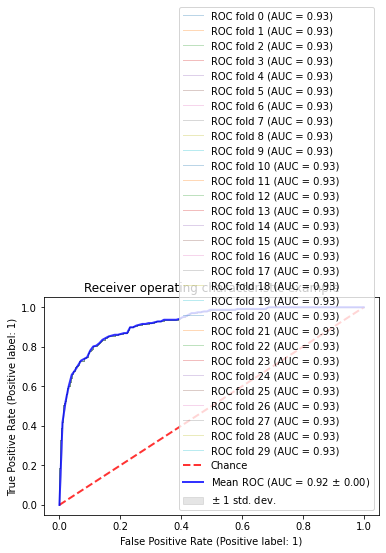

In [115]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
classifier = AdaBoostClassifier(learning_rate= 0.7, n_estimators= 100, algorithm= 'SAMME.R')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(employee_df_prepared_feature_importance_v2, labels)):
    classifier.fit(employee_df_prepared_feature_importance_v2, labels)
    viz = plot_roc_curve(classifier, employee_df_prepared_feature_importance_v2, labels,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [88]:
n_classes = labels.shape[1]
classifier = AdaBoostClassifier(learning_rate= 0.7, n_estimators= 100, algorithm= 'SAMME.R')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [85]:
classifier = AdaBoostClassifier(learning_rate= 0.7, n_estimators= 100, algorithm= 'SAMME.R')

y_score = classifier.fit(employee_df_prepared_feature_importance_v2, labels).decision_function(employee_df_prepared_feature_importance_v2)

## Cluster Analysis

### Create a dataframe with only employees that have quit

In [ ]:
quit_df = employee_df[employee_df.Attrition == 1]
quit_df.head()

In [ ]:
sns.histplot(quit_df.Age, color = 'orange')

We see that a big portion of people that have quit their job are under 35 years old.

In [ ]:
df_subset = employee_df[['Age', 'DailyRate']].copy()
sns.pairplot(df_subset)

In [ ]:
df_subset = quit_df[['Age', 'DailyRate']].copy()
sns.pairplot(df_subset)

In [ ]:
quit_df['DailyRate'].mean()

###From thee ones that quit, nearly half of them

In [ ]:
not_quit_df = employee_df[employee_df.Attrition == 0]
not_quit_df

In [ ]:
df_corr = employee_df.corr(method = 'pearson')
figure = plt.figure(figsize = (16, 10))
sns.heatmap(df_corr, cmap = 'YlGn',annot = True, fmt = '.1g')

Chosing variables for cluster: from the correlation map, althouighj there are no variables with high correelation with the target variable, we choose to analyse clusters on the following features:

- Age
- Education
- Monthly income
- Totalworking years
- Worklife balance

### Quitting Cluster

In [ ]:
clus_quit_df = quit_df[['Age', 'Education', 'MonthlyIncome', 'TotalWorkingYears', 'WorkLifeBalance']].copy()
clus_quit_df

In [ ]:
scaled_clus_quit_df = MinMaxScaler().fit_transform(clus_quit_df)
scaled_clus_quit_df

In [ ]:
cols = clus_quit_df.columns
#index = df_v2.index
scaled_clus_quit_df = pd.DataFrame(scaled_clus_quit_df, columns = cols)
scaled_clus_quit_df

In [ ]:
ks = range(1, 11) # loop between 1 and 10
inertias = [] # also called sum of squared errors (difference between the points of the data and the centroid)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(scaled_clus_quit_df)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

In [ ]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks in x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

In [ ]:
model_k4 = KMeans(n_clusters = 4, random_state = 0)
scaled_clus_quit_df_k4 = scaled_clus_quit_df.copy() # copy the prod dataset in order to join the label column to the original one
model_k4.fit(scaled_clus_quit_df_k4)

In [ ]:
clus_quit_df['label'] = model_k4.labels_
clus_quit_df

In [ ]:
clus_quit_df.groupby(['label']).mean().transpose()

In [ ]:
clus_quit_df['label'].value_counts()

There are four diferent types of people quiting.

1 - Older employees with really high salaries - probably retired

2 - Lower education, lower working years, good worklife balance

3 - High education, worst Work life balance

4 - higher education, lower salaries - apostar nesta em proximos passos


### Not Quitting Cluster

In [ ]:
clus_not_quit_df = not_quit_df[['Age', 'Education', 'MonthlyIncome', 'TotalWorkingYears', 'WorkLifeBalance']].copy()
clus_not_quit_df

In [ ]:
scaled_clus_not_quit_df = MinMaxScaler().fit_transform(clus_not_quit_df)
scaled_clus_not_quit_df

In [ ]:
cols = clus_not_quit_df.columns
#index = df_v2.index
scaled_clus_not_quit_df = pd.DataFrame(scaled_clus_not_quit_df, columns = cols)
scaled_clus_not_quit_df

In [ ]:
ks = range(1, 11) # loop between 1 and 10
inertias = [] # also called sum of squared errors (difference between the points of the data and the centroid)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(scaled_clus_not_quit_df)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

In [ ]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks in x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

In [ ]:
scaled_clus_not_quit_df_k4 = scaled_clus_not_quit_df.copy() # copy the prod dataset in order to join the label column to the original one
model_k4.fit(scaled_clus_not_quit_df_k4)

In [ ]:
clus_not_quit_df['label'] = model_k4.labels_
clus_not_quit_df

In [ ]:
clus_not_quit_df.groupby(['label']).mean().transpose()

In [ ]:
clus_not_quit_df['label'].value_counts()

## Principal Component Analysis - Dimensionality Reduction

## SHAP - Feature Importance